In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3})
tab20_colors = plt.cm.get_cmap('tab20').colors

import os, pickle, torch
import numpy as np

# Load trained model from similarity regularization

In [2]:
cache_dir = 'cache'
models_dir = 'cnn_models'

with open(os.path.join(models_dir, 'model.ids.pickle'), 'rb') as f:
    catalog = pickle.load(f)

In [3]:
print('accuracy on clean dataset')
clean_accs = {}
for key, model_ids in catalog.items():
    clean_accs[key] = []
    for model_id in model_ids:
        saved = torch.load(os.path.join(models_dir, 'exported', f'{model_id}.pt'))
        clean_accs[key].append(saved['accs']['test'][saved['best_epoch']])
    if clean_accs[key]:
        print('{:10} {:.2%} ({:.2%})'.format('\'{}\':'.format(key), np.mean(clean_accs[key]), np.std(clean_accs[key])/len(clean_accs[key])**0.5))

accuracy on clean dataset
'none':    92.36% (0.16%)
'neural':  89.13% (0.15%)
'shuffle': 89.58% (0.00%)


# Test model robustness against random distortions

In [4]:
from roarena.tester import test_random_distortions

distortions = [
    ('Gaussian', 0.05),
    ('Gaussian', 0.15),
    ('Uniform', 0.1),
    ('Uniform', 0.3),
    ('SaltPepper', 0.04),
    ('SaltPepper', 0.12),
]

# test models with random distortions
noisy_accs = {}
for key, model_ids in catalog.items():
    print('testing {} \'{}\' models...'.format(len(model_ids), key))
    noisy_accs[key] = {}
    for d_type, d_val in distortions:
        noisy_accs[key][(d_type, d_val)] = []
    for model_id in model_ids:
        print(model_id)
        saved = torch.load(os.path.join(models_dir, 'exported', f'{model_id}.pt'))
        model = saved['model']
        for d_type, d_val in distortions:
            _, acc = test_random_distortions(
                saved['config']['model_config']['task'], model, d_type, d_val,
                cache_dir, benchmarks_dir='benchmarks'
            )
            noisy_accs[key][(d_type, d_val)].append(acc)

# gather results
accs_mean = np.full((len(catalog), len(distortions)+1), np.nan)
accs_sem = np.full((len(catalog), len(distortions)+1), np.nan)
catalog_keys = list(catalog.keys())
d_labels = [f'{d_type}-{d_val}' for d_type, d_val in distortions]
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        accs_mean[k_idx, 0] = np.mean(clean_accs[key])
        accs_sem[k_idx, 0] = np.std(clean_accs[key])/len(clean_accs[key])**0.5

        for d_idx, (d_type, d_val) in enumerate(distortions, 1):
            accs_mean[k_idx, d_idx] = np.mean(noisy_accs[key][(d_type, d_val)])
            accs_sem[k_idx, d_idx] = np.std(noisy_accs[key][(d_type, d_val)])/len(noisy_accs[key][(d_type, d_val)])**0.5

testing 5 'none' models...
8956FAC3
EAE1625A
E0D869C0
4EB279F4
A8E8F7CD
testing 3 'neural' models...
4B006298
95DEAC78
37CB4C0A
testing 1 'shuffle' models...
8B29B9CA


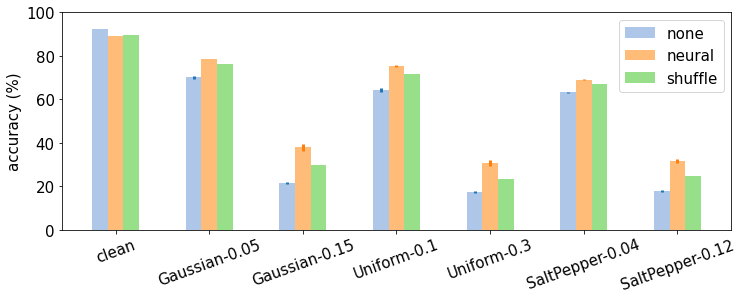

In [5]:
_, ax = plt.subplots(figsize=(12, 4))

width = 0.5/len(catalog)
h_bars = []
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        x = np.arange(len(distortions)+1)+(k_idx-(len(catalog)-1)/2)*width
        h_bars.append(ax.bar(x, accs_mean[k_idx]*100, width, facecolor=fcolor))
        ax.errorbar(x, accs_mean[k_idx]*100, accs_sem[k_idx]*100, linestyle='none', ecolor=ecolor)
ax.set_xticks(np.arange(len(distortions)+1))
ax.set_xticklabels(['clean']+d_labels, rotation=20)
ax.set_ylabel('accuracy (%)')
ax.set_ylim([0, 100])
ax.legend(h_bars, catalog_keys)
plt.show()